# Reaction Rate Lookup in RMG

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rmgpy.data.thermo
import rmgpy.data.kinetics
import rmgpy.reaction
import rmgpy.species


import rmgpy.chemkin

## Loading Reactions from Existing Mechanism

In [2]:
# load a model from chemkin
surf_chemkin = 'co_oxidation_rmg/chemkin/chem_annotated-surface.inp'
gas_chemkin = 'co_oxidation_rmg/chemkin/chem_annotated-gas.inp'
species_dict = 'co_oxidation_rmg/chemkin/species_dictionary.txt'
gas_spec, gas_rxn = rmgpy.chemkin.load_chemkin_file(gas_chemkin, dictionary_path=species_dict)
surf_spec, surf_rxn = rmgpy.chemkin.load_chemkin_file(surf_chemkin, dictionary_path=species_dict)

SDEN = 2.7200E-09 * 10000

species = gas_spec + surf_spec
reactions = gas_rxn + surf_rxn

In [3]:
for spec in species:
    print(spec)

Ar
Ne
N2
O2(3)
CO2(4)
CO(5)
X(1)
OX(2)
OCX(14)
CO2X2(24)
COX2(33)
CO2X3(37)


In [4]:
for rxn in reactions:
    print(rxn)

OX(2) + OX(2) <=> X(1) + X(1) + O2(3)
OCX(14) <=> X(1) + CO(5)
X(1) + X(1) + CO2(4) <=> OX(2) + OCX(14)
X(1) + OCX(14) <=> COX2(33)
X(1) + X(1) + CO2(4) <=> CO2X2(24)
CO2X2(24) <=> OX(2) + OCX(14)
CO2X3(37) <=> OX(2) + COX2(33)
X(1) + CO2X2(24) <=> CO2X3(37)
OCX(14) + CO2X3(37) <=> COX2(33) + CO2X2(24)


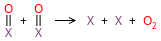

In [5]:
# Display the reaction of interest
reactions[0]

In [6]:
reactions[0].kinetics

Arrhenius(A=(3.7e+21,'cm^3/(mol*s)'), n=0, Ea=(66.611,'kcal/mol'), T0=(1,'K'))

In [7]:
# Lookup rate coefficient at T=1000K
T = 1000.0
reactions[0].get_rate_coefficient(T)

# NOTE this is incorrect, the units are wrong and it should be a SurfaceArrhenius instead of Arrhenius. I'm looking into the the issue

10.249108147236555

In [8]:
reactions[0].library

'Surface/CPOX_Pt/Deutschmann2006_adjusted'

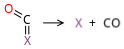

In [9]:
# repeat for reaction 1
reactions[1]

In [10]:
print(reactions[1].kinetics)
print(reactions[1].get_rate_coefficient(T, surface_site_density=SDEN))

Arrhenius(A=(1e+11,'s^-1'), n=0, Ea=(40.511,'kcal/mol'), T0=(1,'K'))
140.1246669168738


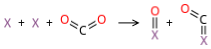

In [11]:
# repeat for reaction 2
reactions[2]

In [12]:
print(reactions[2].kinetics)
print(reactions[2].get_rate_coefficient(T, surface_site_density=SDEN))

StickingCoefficient(A=0.02, n=0, Ea=(10,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [Adsorbate;VacantSite1;VacantSite2] for rate rule [CO2;VacantSite1;VacantSite2]
Euclidian distance = 2.0
Multiplied by reaction path degeneracy 2.0
family: Surface_Adsorption_Dissociative_Double""")
30584013.06673674


## Looking up Reaction Rate Programmatically

In [18]:
# Load Thermo Database
thermo_library_path = "/home/moon/rmg/RMG-database/input/thermo/"
thermo_database = rmgpy.data.thermo.ThermoDatabase()
thermo_database.load(
    thermo_library_path,
    libraries = ['primaryThermoLibrary']
#     libraries = [
#         'surfaceThermoPt111',
#     ],
#     surface='Pt'
)

In [20]:
# Load Kinetics Database (quick, automatically loads recommended families)
ref_library_path = "/home/moon/rmg/RMG-database/input/kinetics/"
ref_database = rmgpy.data.kinetics.KineticsDatabase()
ref_database.load(
    ref_library_path,
    libraries=[
        'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    ],
    families=[]
)

### Load Species Individually

In [21]:
# reaction 0
o2 = rmgpy.species.Species(smiles='[O][O]')

Pt = rmgpy.species.Species()
Pt.from_adjacency_list("""
1 X u0 p0 c0
""")

ox = rmgpy.species.Species()
ox.from_adjacency_list("""
1 X u0 p0 c0 {2,D}
2 O u0 p2 c0 {1,D}
""")

# store the species in a reaction object
reaction0 = rmgpy.reaction.Reaction(
    reactants = [ox, ox],
    products = [Pt, Pt, o2]
)

In [22]:
# reaction 1
CO = rmgpy.species.Species(smiles='[C-]#[O+]')

Pt = rmgpy.species.Species()
Pt.from_adjacency_list("""
1 X u0 p0 c0
""")

OCX = rmgpy.species.Species()
OCX.from_adjacency_list("""
1 O u0 p2 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,D}
3 X u0 p0 c0 {2,D}
""")

# store the species in a reaction object
reaction1 = rmgpy.reaction.Reaction(
    reactants = [OCX],
    products = [Pt, CO]
)

In [23]:
# reaction 2
Pt = rmgpy.species.Species()
Pt.from_adjacency_list("""
1 X u0 p0 c0
""")

co2 = rmgpy.species.Species(smiles='O=C=O')

ox = rmgpy.species.Species()
ox.from_adjacency_list("""
1 X u0 p0 c0 {2,D}
2 O u0 p2 c0 {1,D}
""")

OCX = rmgpy.species.Species()
OCX.from_adjacency_list("""
1 O u0 p2 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,D}
3 X u0 p0 c0 {2,D}
""")

ox.thermo = thermo_database.get_thermo_data(ox)
o2.thermo = thermo_database.get_thermo_data(o2)
Pt.thermo = thermo_database.get_thermo_data(Pt)
OCX.thermo = thermo_database.get_thermo_data(OCX)
co2.thermo = thermo_database.get_thermo_data(co2)

# store the species in a reaction object
reaction2 = rmgpy.reaction.Reaction(
    reactants = [Pt, Pt, co2],
    products = [ox, OCX]
)

ERROR:root:Error attempting to get thermo for species O=[Pt] with structure 
1 X u0 p0 c0 {2,D}
2 O u0 p2 c0 {1,D}



KeyError: 'metal'

## Lookup Reaction in Libraries

In [ ]:
# Reaction 0
lib_rxns = []
for lib_key in ref_database.libraries:
    lib = ref_database.libraries[lib_key]
    rxns = ref_database.generate_reactions_from_library(lib, reaction0.reactants, products=reaction0.products)
    for r in rxns:
        lib_rxns.append(r)
print(lib_rxns)

# Use reaction kinetics to estimate rate
if len(lib_rxns) > 0:
    lib_rxns[0].get_rate_coefficient(T)

In [ ]:
# Reaction 1
lib_rxns = []
for lib_key in ref_database.libraries:
    lib = ref_database.libraries[lib_key]
    rxns = ref_database.generate_reactions_from_library(lib, reaction1.reactants, products=reaction1.products)
    for r in rxns:
        lib_rxns.append(r)
print(lib_rxns)

# Use reaction kinetics to estimate rate
if len(lib_rxns) > 0:
    lib_rxns[0].get_rate_coefficient(T)

In [ ]:
# Reaction 2 -- not found in library
lib_rxns = []
for lib_key in ref_database.libraries:
    lib = ref_database.libraries[lib_key]
    rxns = ref_database.generate_reactions_from_library(lib, reaction2.reactants, products=reaction2.products)
    for r in rxns:
        lib_rxns.append(r)
print(lib_rxns)

# Use reaction kinetics to estimate rate
if len(lib_rxns) > 0:
    lib_rxns[0].get_rate_coefficient(T)

## Lookup Reaction in Families if not found in Libraries

Triplet O2 and CO are both kind of strange exceptions and so the first two reactions do not fit any current reaction templates. Reaction 2 does produce a match

In [21]:
# try to match reaction 0
templates = ref_database.generate_reactions_from_families(reaction0.reactants, products=reaction0.products)
print(templates)

[]


In [22]:
# try to match reaction 1
templates = ref_database.generate_reactions_from_families(reaction1.reactants, products=reaction1.products)
print(templates)

[]


In [23]:
# try to match reaction 2
templates = ref_database.generate_reactions_from_families(reaction2.reactants, products=reaction2.products)
print(templates)

[TemplateReaction(reactants=[Species(label="[Pt]", molecule=[Molecule(smiles="[Pt]")], molecular_weight=(0,'amu')), Species(label="[Pt]", molecule=[Molecule(smiles="[Pt]")], molecular_weight=(0,'amu')), Species(label="O=C=O", molecule=[Molecule(smiles="O=C=O")], molecular_weight=(44.0094,'amu'))], products=[Species(label="O=[Pt]", molecule=[Molecule(smiles="O=[Pt]")], molecular_weight=(15.9994,'amu')), Species(label="O=C=[Pt]", molecule=[Molecule(smiles="O=C=[Pt]")], molecular_weight=(28.01,'amu'))], pairs=[[Species(label="O=C=O", molecule=[Molecule(smiles="O=C=O")], molecular_weight=(44.0094,'amu')), Species(label="O=[Pt]", molecule=[Molecule(smiles="O=[Pt]")], molecular_weight=(15.9994,'amu'))], [Species(label="O=C=O", molecule=[Molecule(smiles="O=C=O")], molecular_weight=(44.0094,'amu')), Species(label="O=C=[Pt]", molecule=[Molecule(smiles="O=C=[Pt]")], molecular_weight=(28.01,'amu'))]], family='Surface_Adsorption_Dissociative_Double', template=['CO2', 'VacantSite1', 'VacantSite2'])

In [24]:
# Estimate the reaction rate for reaction 2
family_kinetics_bep = ref_database.families[templates[0].family].get_kinetics(reaction2, templates[0].template)[0][0]
print(type(family_kinetics_bep))
# StickingCoefficientBEP is not enough to estimate kinetics, need to convert to StickingCoefficient using enthalpy of reaction

dH = reaction2.get_enthalpy_of_reaction(1000)
reaction2.kinetics = family_kinetics_bep.to_arrhenius(dH)
print(type(reaction2.kinetics))

# SDEN *=10000
reaction2.get_rate_coefficient(T, surface_site_density=SDEN)

<class 'rmgpy.kinetics.surface.StickingCoefficientBEP'>
<class 'rmgpy.kinetics.surface.StickingCoefficient'>


15292006.53336837

## Plot Reaction Rate vs. Inverse Temperature

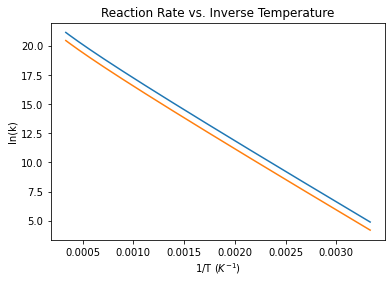

In [25]:
%matplotlib inline
plt.xlabel('1/T ($K^{-1})$')
plt.ylabel('ln(k)')
plt.title('Reaction Rate vs. Inverse Temperature')
T_ = np.linspace(300, 3000, 1001)
T_inv = 1.0 / T_

k_saved_mechanism = np.zeros(len(T_))
k_programmatic = np.zeros(len(T_))
for i in range(0, len(T_)):
    k_saved_mechanism[i] = reactions[2].get_rate_coefficient(T_[i], surface_site_density=SDEN)
    k_programmatic[i] = reaction2.get_rate_coefficient(T_[i], surface_site_density=SDEN)
plt.plot(T_inv, np.log(k_saved_mechanism), T_inv, np.log(k_programmatic))

# NOTE the saved mechanism is from several months ago and there have been many updates to RMG in the meantime.